In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow_hub as hub
import tensorflow_text as text

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
papers = pd.read_csv('./data/data.csv')
print(papers.columns)
papers.rename(columns={'content': 'paper_text'}, inplace=True)
papers['paper_text'].astype(str)

Index(['content', 'label', 'start'], dtype='object')


0                                            Áo bao đẹp ạ!
1                                                Tuyệt vời
2                                2day ao khong giong trong
3                               Mùi thơm,bôi lên da mềm da
4                                         Vải đẹp, dày dặn
                               ...                        
31455                                      Không đáng tiền
31456                                         Quần rất đẹp
31457                               Hàng đẹp đúng giá tiền
31458                                      Chất vải khá ổn
31459    áo rất ok nhé , vải mịn , len cao cổ này phối ...
Name: paper_text, Length: 31460, dtype: object

In [12]:
import numpy as np
# duplicated
print(papers.duplicated().sum())
papers.drop_duplicates(inplace=True)

# drop nan
papers.dropna(axis=0, inplace=True, how="any")
# drop inf
papers.replace([np.inf, -np.inf], np.nan, inplace=True)
papers.replace('', np.nan, inplace=True)
papers.dropna(inplace=True,how='any',axis=0)
# Remove the columns
try:
    papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)
except:
    pass

# Print out the first rows of papers
print(papers.head())
print(papers.info())
papers.reset_index(inplace=True, drop=True)

4259
                   paper_text label  start
0               Áo bao đẹp ạ!   POS      5
1                   Tuyệt vời   POS      5
2   2day ao khong giong trong   NEG      1
3  Mùi thơm,bôi lên da mềm da   POS      5
4            Vải đẹp, dày dặn   POS      5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27196 entries, 0 to 31459
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paper_text  27196 non-null  object
 1   label       27196 non-null  object
 2   start       27196 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 849.9+ KB
None


In [13]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# replace \n
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: re.sub('\n', ' ', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'][0]

'áo bao đẹp ạ'

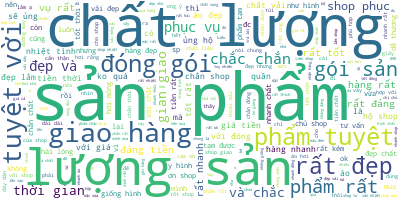

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [15]:

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string
import re
import pyvi
from pyvi import ViTokenizer, ViPosTagger
from underthesea import word_tokenize
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words = set(open("./data/vietnamese-stopwords-dash.txt", "r", encoding="utf-8").read().splitlines())

def remove_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_number(text):
    return re.sub(r'\d+', '', text).strip()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_punctuation_not_underscore(text): # remove dấu câu để lại dấu _
    # Tạo một bản sao của string.punctuation và loại bỏ dấu _
    punctuation = string.punctuation.replace("_", "")
    # punctuation = punctuation.replace("-", "")
    return text.translate(str.maketrans('', '', punctuation))

def remove_(text):
    text = remove_punctuation_not_underscore(text)
    text = remove_number(text)
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    text = text.replace("_  _", "_")
    return re.sub(r'“|”', '', text).strip()
    # return ''.join(char for char in text if char not in ['“', '”'])

def remove_punctuation_underscore(text): # remove dấu _
    punctuation = "_"
    return text.translate(str.maketrans('', '', punctuation))
    
def word_to_phrase(text): # chuyển từ thành cụm từ
    # return ViTokenizer.tokenize(text)
    return word_tokenize(text, format="text")

# def sent_to_words(sentences):
#     for sentence in sentences:
#         # deacc=True removes punctuations
#         # loại bỏ dấu câu and split
#         yield([remove_(str(word)) for word in re.findall(r'\w+|\S+', word_to_phrase(str(sentence))) if remove_(str(word)) != ''])

def remove_stopwords(texts):
    words = [word for word in texts.split() if word not in stop_words]
    words_to_sentence = ' '.join(words)
    return words_to_sentence.strip()

def remove_emoj(text):
    emoj = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002500-\U00002BEF"  # chinese char
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642" 
                        u"\u2600-\u2B55"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                                    "]+", re.UNICODE)
    return re.sub(emoj, '', text)

# drop url
def remove_url(text):
    text = re.sub(r'http\S+', '', text).strip()
    text = re.sub(r'www\S+', '', text).strip()
    text = re.sub(r'pic\S+', '', text).strip()
    text = re.sub(r'bit.ly\S+', '', text).strip()
    text = re.sub(r'fb\S+', '', text).strip()
    text = re.sub(r'com\S+', '', text).strip()
    text = re.sub(r'https\S+', '', text).strip()
    return text
# drop email
def remove_email(text):
    # \S kí tự không phải khoảng trắng
    # \S* kí tự không phải khoảng trắng xuất hiện 0 hoặc nhiều lần
    # \s? có thể có hoặc không có khoảng trắng cuối chuỗi
    return re.sub(r'\S*@\S*\s?', '', text).strip()

data = papers['paper_text_processed']
data = data.apply(lambda x: remove_whitespace(x))
data = data.apply(lambda x: remove_emoj(x))
data = data.apply(lambda x: remove_email(x))
data = data.apply(lambda x: remove_url(x)) 
data = data.apply(lambda x: remove_number(x))
# data = data.apply(lambda x: remove_punctuation_underscore(x))
data = data.apply(lambda x: word_to_phrase(x))
data = data.apply(lambda x: remove_(x))
data = data.apply(lambda x: remove_stopwords(x))
print('text 0: ',data[0])
print('text 1: ',data[1])
print('text 2: ',data[2])
# print(remove_stopwords(text))
docs = data.tolist()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vuanh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vuanh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


text 0:  áo bao đẹp
text 1:  tuyệt_vời
text 2:  day ao khong_giong


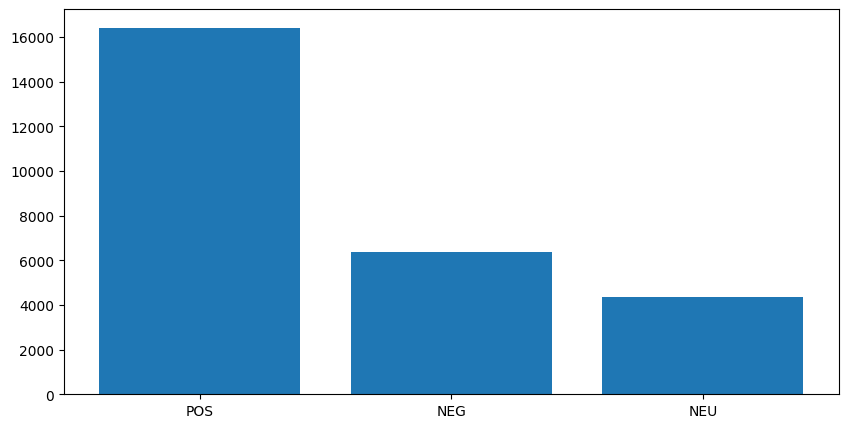

In [16]:
label = papers['label'].value_counts()
label
fig,ax = plt.subplots(figsize=(10,5))
ax.bar(label.index, label.values)
plt.show()

In [17]:
label = papers['label'].tolist()
print(len(label))
print(len(docs))

27196
27196


In [18]:
df = pd.DataFrame({'docs': docs, 'label': label})
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
train['label'].value_counts()

POS    13139
NEG     5140
NEU     3477
Name: label, dtype: int64

In [20]:
labelE = LabelEncoder()
train['label'] = labelE.fit_transform(train['label'])
print(train['label'].value_counts())
y_train = train['label'].tolist()
x_train = train['docs'].tolist()

test['label'] = labelE.transform(test['label'])
print(test['label'].value_counts())
y_test = test['label'].tolist()
x_test = test['docs'].tolist()

2    13139
0     5140
1     3477
Name: label, dtype: int64
2    3289
0    1248
1     903
Name: label, dtype: int64


In [21]:
import tensorflow_hub as hub
import tensorflow_text as text

In [23]:
from bert import tokenization

In [24]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [25]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        # print(text)
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [26]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [27]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(3, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [28]:
max_len = 250
train_input = bert_encode(x_train, tokenizer, max_len=max_len)
test_input = bert_encode(x_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(y_train)

In [29]:
print(train_labels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [30]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 250)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 250)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 250)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 250, 768)]                'input_mask[0][0]',         

d:\anaconda\envs\django_and_AI\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./models/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


In [37]:
train_sh = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=4,
    verbose=1
)

Epoch 1/10
4351/4351 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.7645
Epoch 1: val_accuracy improved from 0.75092 to 0.75115, saving model to ./models\model.h5
4351/4351 [==============================] - 266s 61ms/step - loss: 0.5844 - accuracy: 0.7645 - val_loss: 0.6323 - val_accuracy: 0.7511
Epoch 2/10
4351/4351 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.7816
Epoch 2: val_accuracy did not improve from 0.75115
4351/4351 [==============================] - 262s 60ms/step - loss: 0.5453 - accuracy: 0.7816 - val_loss: 0.6608 - val_accuracy: 0.7452
Epoch 3/10
4351/4351 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.8017
Epoch 3: val_accuracy did not improve from 0.75115
4351/4351 [==============================] - 262s 60ms/step - loss: 0.5011 - accuracy: 0.8017 - val_loss: 0.7087 - val_accuracy: 0.7493
Epoch 4/10
4351/4351 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8244
Epoch 4:

In [38]:
model.save('./models/model1.h5')

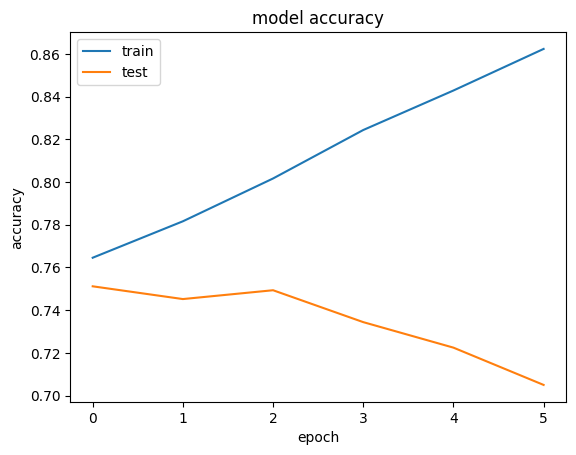

In [39]:
plt.plot(train_sh.history['accuracy'])
plt.plot(train_sh.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()